Selected numeric features: ['traffic_ordinal', 'peak_traffic', 'rush_hour', 'multi_peak', 'delay_weekend', 'distance_traffic', 'distance_km', 'multiple_deliveries', 'hour_of_order', 'dist_order_hour', 'delivery_person_ratings', 'order_dayofweek']

Running SHAP...


C:\Users\User\AppData\Local\Temp\ipykernel_26784\3320423831.py:230: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_sample, feature_names=feature_names)


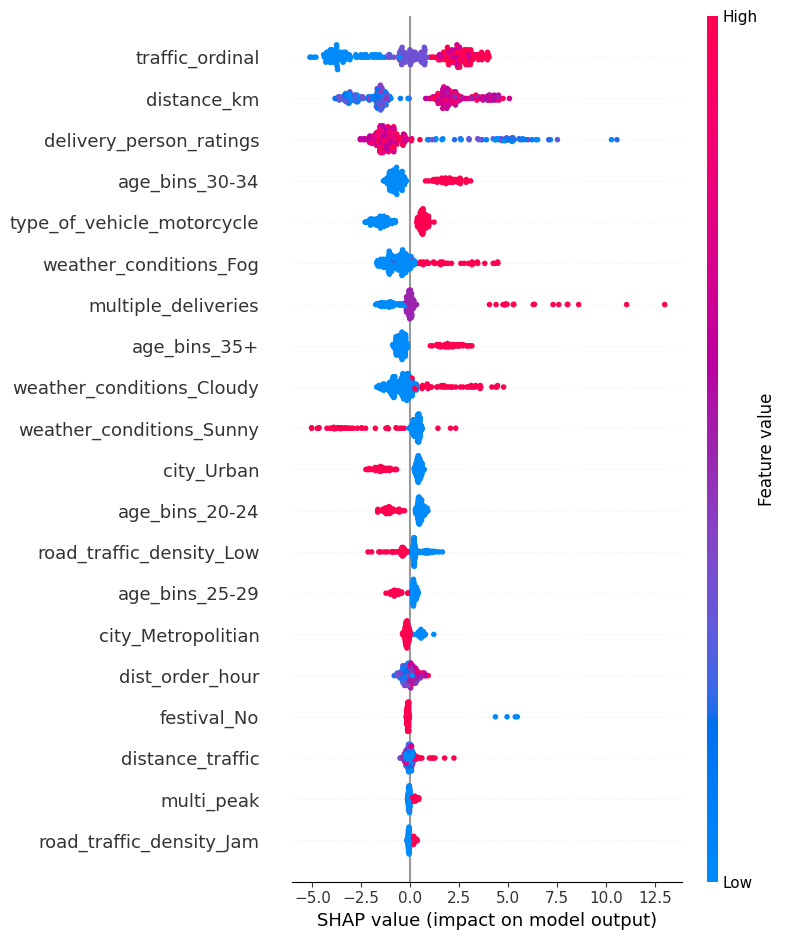

✔ SHAP completed without errors


In [3]:
# ============================================================
# CLEAN DELIVERY ETA PIPELINE (SAFE FOR SHAP, NO ERRORS)
# ============================================================

import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from xgboost import XGBRegressor

# ============================================================
# 1. LOAD + BASIC CLEANING
# ============================================================

df = pd.read_csv("Dataset.csv")
df.columns = [c.lower() for c in df.columns]
df.rename(columns={"time_taken (min)": "time_taken_min"}, inplace=True)

df["order_date"] = pd.to_datetime(df["order_date"], format="%d-%m-%Y", errors="coerce")
df = df.dropna(subset=["order_date"]).reset_index(drop=True)

# positive GPS
gps_cols = [
    "restaurant_latitude", "restaurant_longitude",
    "delivery_location_latitude", "delivery_location_longitude"
]
df[gps_cols] = df[gps_cols].abs()

# ============================================================
# 2. FEATURE ENGINEERING
# ============================================================

df["order_month"] = df["order_date"].dt.strftime('%b')

bins = [20, 25, 30, 35, 50]
labels = ["20-24", "25-29", "30-34", "35+"]
df["age_bins"] = pd.cut(df["delivery_person_age"], bins=bins, labels=labels)

df["time_orderd"] = pd.to_datetime(df["time_orderd"], format="%H:%M", errors="coerce")

df["peak_hours"] = df["time_orderd"].dt.hour.apply(
    lambda h: 1 if (11 <= h < 14) or (17 <= h < 21) else 0
)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    return 2 * R * np.arcsin(np.sqrt(
        np.sin((lat2-lat1)/2)**2 +
        np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2)**2
    ))

df["distance_km"] = haversine(
    df["restaurant_latitude"], df["restaurant_longitude"],
    df["delivery_location_latitude"], df["delivery_location_longitude"]
)

df["order_dayofweek"] = df["order_date"].dt.dayofweek
df["is_weekend"] = df["order_dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

df["hour_of_order"] = df["time_orderd"].dt.hour
df["day_of_month"] = df["order_date"].dt.day
df["week_of_year"] = df["order_date"].dt.isocalendar().week.astype(int)

df["distance_traffic"] = df["distance_km"] * df["peak_hours"]
df["delay_weekend"] = df["peak_hours"] * df["is_weekend"]
df["rating_vehicle"] = df["delivery_person_ratings"] * df["vehicle_condition"]
df["driver_score"] = df["delivery_person_ratings"] * (df["vehicle_condition"] / 10)
df["dist_order_hour"] = df["distance_km"] * df["hour_of_order"]

df["peak_traffic"] = df["peak_hours"]
df["multi_peak"] = df["multiple_deliveries"] * df["peak_hours"]

def is_rush_hour(h):
    return 1 if (11 <= h < 15) or (18 <= h < 22) else 0

df["rush_hour"] = df["hour_of_order"].apply(is_rush_hour)

traffic_map = {"low": 1, "medium": 2, "high": 3, "jam": 4}
df["traffic_ordinal"] = df["road_traffic_density"].str.lower().map(traffic_map)

df["distance_bin"] = pd.qcut(df["distance_km"], 5, labels=False, duplicates="drop")

def part_of_day(h):
    if 5 <= h < 11: return "morning"
    if 11 <= h < 15: return "lunch"
    if 15 <= h < 18: return "afternoon"
    if 18 <= h < 22: return "evening"
    return "night"

df["part_of_day"] = df["hour_of_order"].apply(part_of_day)

# ============================================================
# 3. CLUSTERING + FIX ZONES (100% safe)
# ============================================================

coords_rest = df[["restaurant_latitude", "restaurant_longitude"]]
coords_cust  = df[["delivery_location_latitude", "delivery_location_longitude"]]

kmeans_rest = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_cust = KMeans(n_clusters=5, random_state=42, n_init=10)

df["restaurant_zone"] = kmeans_rest.fit_predict(coords_rest)
df["customer_zone"]   = kmeans_cust.fit_predict(coords_cust)

# ---------- ALWAYS CLEAN ZONES ----------
df["restaurant_zone"] = df["restaurant_zone"].astype(int).astype(str)
df["customer_zone"]   = df["customer_zone"].astype(int).astype(str)

joblib.dump(kmeans_rest, "restaurant_kmeans.pkl")
joblib.dump(kmeans_cust, "customer_kmeans.pkl")

# ============================================================
# 4. FEATURES
# ============================================================

numeric_features = [
    "distance_km","distance_traffic","driver_score",
    "delivery_person_age","delivery_person_ratings","vehicle_condition",
    "multiple_deliveries","order_dayofweek","week_of_year","day_of_month",
    "hour_of_order","rush_hour","traffic_ordinal","rating_vehicle",
    "delay_weekend","dist_order_hour","peak_traffic","multi_peak"
]

categorical_features = [
    "weather_conditions","road_traffic_density","type_of_order",
    "type_of_vehicle","festival","city","order_month",
    "age_bins","part_of_day","restaurant_zone","customer_zone","distance_bin"
]

# ============================================================
# 5. PCA SELECTION
# ============================================================

df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())
scaled = StandardScaler().fit_transform(df[numeric_features])

pca = PCA().fit(scaled)
loadings = pd.DataFrame(
    np.abs(pca.components_.T) * pca.explained_variance_ratio_,
    index=numeric_features
)

selected_num_features = loadings.sum(axis=1).sort_values(ascending=False).head(12).index.tolist()
print("Selected numeric features:", selected_num_features)

# ============================================================
# 6. TRAIN / TEST
# ============================================================

X = df[selected_num_features + categorical_features]
y = df["time_taken_min"]

final_data = pd.concat([X, y], axis=1)
final_data.to_csv("final_data.csv", index=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ============================================================
# 7. PREPROCESSOR
# ============================================================

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, selected_num_features),
    ("cat", categorical_transformer, categorical_features)
])

# ============================================================
# 8. MODEL
# ============================================================

model = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

model.fit(X_train, y_train)
joblib.dump(model, "final_delivery_time_xgb.pkl")

# ============================================================
# 9. SHAP (SAFE — no strings)
# ============================================================

print("\nRunning SHAP...")

pre_fitted = model.named_steps["preprocessor"]
xgb_model  = model.named_steps["xgb"]

X_test_transformed = pre_fitted.transform(X_test)

cat_ohe = pre_fitted.named_transformers_["cat"].named_steps["onehot"]
cat_names = cat_ohe.get_feature_names_out(categorical_features)

feature_names = list(selected_num_features) + list(cat_names)

masker = shap.maskers.Independent(X_test_transformed)
explainer = shap.explainers.Permutation(xgb_model.predict, masker)

X_sample = X_test_transformed[:300]
shap_values = explainer(X_sample)

shap.summary_plot(shap_values.values, X_sample, feature_names=feature_names)

print("✔ SHAP completed without errors")


# classification

✔ Saved restaurant_kmeans.pkl & customer_kmeans.pkl

📌 REGRESSION: Selected numeric features:
['traffic_ordinal', 'peak_traffic', 'rush_hour', 'multi_peak', 'delay_weekend', 'distance_traffic', 'distance_km', 'multiple_deliveries', 'hour_of_order', 'dist_order_hour', 'delivery_person_ratings', 'order_dayofweek']
✔ Saved final_data_regression.csv

🔧 Training REGRESSION model (ETA)...

===== REGRESSION (ETA) PERFORMANCE =====
Train R2: 0.7918556332588196
Test  R2: 0.7560884952545166
MAE     : 3.629406213760376
RMSE    : 4.638489305617733
✔ Saved regression model as final_delivery_time_xgb.pkl
✔ Saved final_data_classification.csv

🔧 Training CLASSIFICATION models (with PCA)...

➡ Training: Logistic Regression

➡ Training: Random Forest

➡ Training: Gradient Boosting

➡ Training: SVM (RBF)

➡ Training: KNN

➡ Training: XGBoost

📊 PCA-based Cross-Validation Results:


,Model,Accuracy,F1,ROC_AUC,Precision,Recall
5,XGBoost,0.921134,0.861313,0.892403,0.905579,0.821182
2,Gradient Boosting,0.918639,0.856896,0.889298,0.901465,0.816543
3,SVM (RBF),0.915732,0.847427,0.878044,0.921189,0.784613
1,Random Forest,0.899745,0.810930,0.848304,0.926929,0.720753
0,Logistic Regression,0.878109,0.784393,0.839335,0.830449,0.743195
4,KNN,0.874297,0.759312,0.814025,0.885727,0.664517



🏆 Best classification model after PCA: XGBoost


C:\Users\User\Miniconda3\envs\myConda\lib\site-packages\xgboost\training.py:199: UserWarning: [21:12:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📘 FINAL CLASSIFICATION REPORT (Best Model):
              precision    recall  f1-score   support

           0     0.9315    0.9651    0.9480      6397
           1     0.9104    0.8331    0.8700      2720

    accuracy                         0.9257      9117
   macro avg     0.9210    0.8991    0.9090      9117
weighted avg     0.9252    0.9257    0.9248      9117

Test ROC-AUC: 0.9764
Test Accuracy: 0.9257


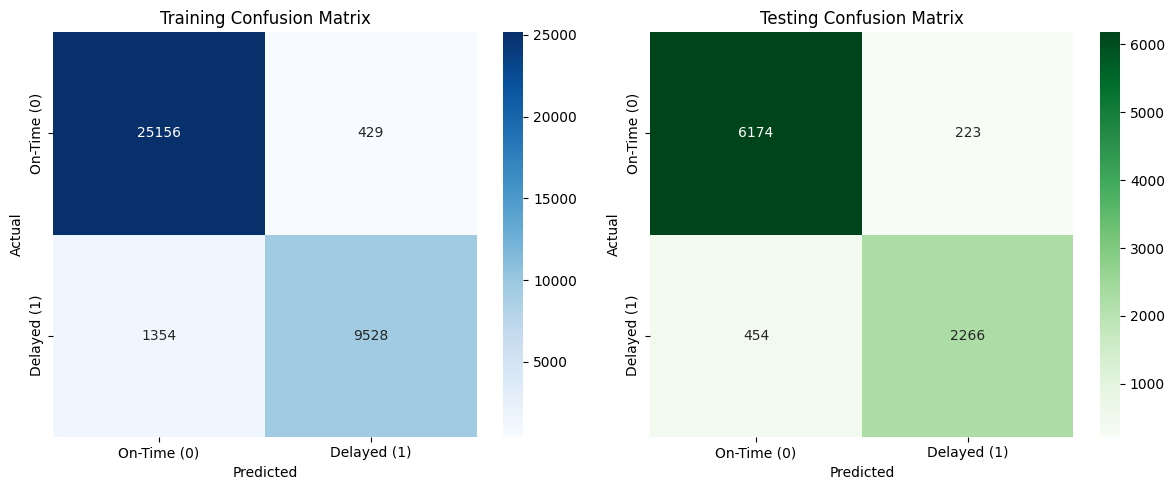


📘 TRAIN METRICS (Best Model):
Accuracy:  0.9511
Precision: 0.9569
Recall:    0.8756
F1 Score:  0.9144

📗 TEST METRICS (Best Model):
Accuracy:  0.9257
Precision: 0.9104
Recall:    0.8331
F1 Score:  0.8700
✔ Saved classification model as delivery_delay_classifier.pkl

📌 Running SHAP on regression model (ETA)...


C:\Users\User\AppData\Local\Temp\ipykernel_41004\558788279.py:449: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_reg.values, X_sample_reg, feature_names=feature_names_reg)


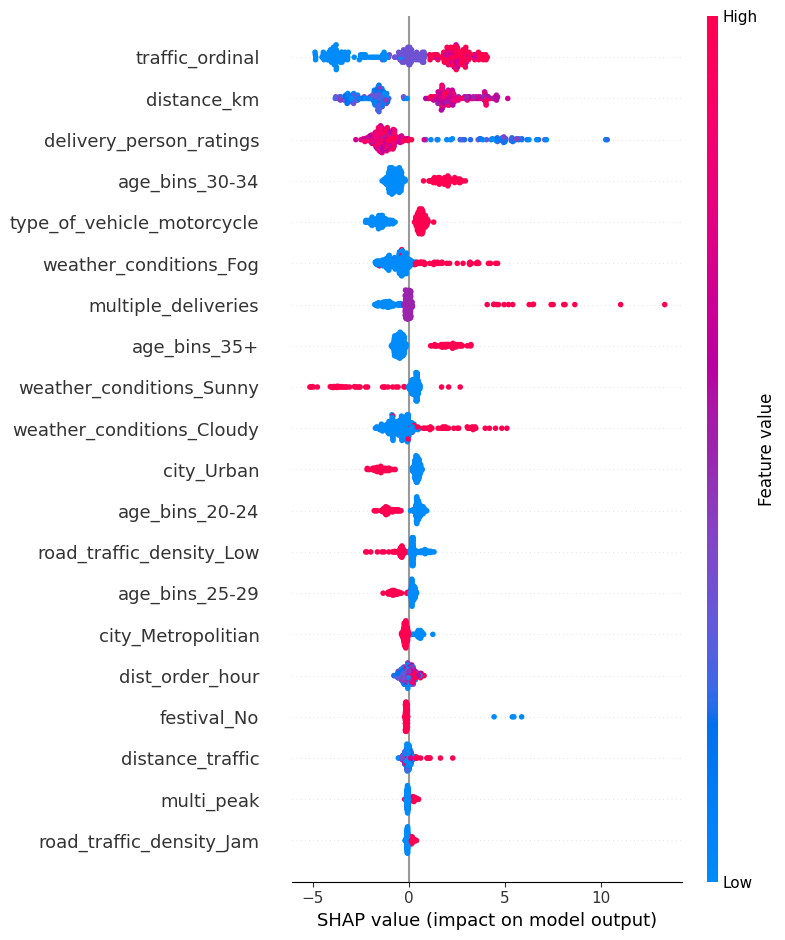

✔ SHAP finished for regression.


In [4]:
# ============================================================
# MASTER TRAINING SCRIPT: REGRESSION + CLASSIFICATION + PCA
# ============================================================

# ---------- Imports ----------
import pandas as pd
import numpy as np
import joblib
import shap

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# Sklearn core
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Regression metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, make_scorer, classification_report, confusion_matrix
)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier

# ============================================================
# 1. LOAD + BASIC CLEANING
# ============================================================

df = pd.read_csv("Dataset.csv")

# Standardize column names
df.columns = [c.lower() for c in df.columns]
df.rename(columns={"time_taken (min)": "time_taken_min"}, inplace=True)

# Parse order_date
df["order_date"] = pd.to_datetime(df["order_date"], format="%d-%m-%Y", errors="coerce")
df = df.dropna(subset=["order_date"]).reset_index(drop=True)

# Fix GPS (absolute values)
gps_cols = [
    "restaurant_latitude", "restaurant_longitude",
    "delivery_location_latitude", "delivery_location_longitude"
]
df[gps_cols] = df[gps_cols].abs()

# ============================================================
# 2. FEATURE ENGINEERING  (SHARED for REG + CLF)
# ============================================================

# Month
df["order_month"] = df["order_date"].dt.strftime('%b')

# Age bins
bins = [20, 25, 30, 35, 50]
labels = ["20-24", "25-29", "30-34", "35+"]
df["age_bins"] = pd.cut(df["delivery_person_age"], bins=bins, labels=labels)

# Time ordered
df["time_orderd"] = pd.to_datetime(df["time_orderd"], format="%H:%M", errors="coerce")

# Peak hours (lunch + evening)
df["peak_hours"] = df["time_orderd"].dt.hour.apply(
    lambda h: 1 if (11 <= h < 14) or (17 <= h < 21) else 0
)

# Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    return 2 * R * np.arcsin(np.sqrt(
        np.sin(dlat/2)**2 +
        np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    ))

df["distance_km"] = haversine(
    df["restaurant_latitude"], df["restaurant_longitude"],
    df["delivery_location_latitude"], df["delivery_location_longitude"]
)

# Calendar parts
df["order_dayofweek"] = df["order_date"].dt.dayofweek
df["is_weekend"] = df["order_dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

df["hour_of_order"] = df["time_orderd"].dt.hour
df["day_of_month"] = df["order_date"].dt.day
df["week_of_year"] = df["order_date"].dt.isocalendar().week.astype(int)

# Interactions
df["distance_traffic"] = df["distance_km"] * df["peak_hours"]
df["delay_weekend"] = df["peak_hours"] * df["is_weekend"]
df["rating_vehicle"] = df["delivery_person_ratings"] * df["vehicle_condition"]
df["driver_score"] = df["delivery_person_ratings"] * (df["vehicle_condition"] / 10)
df["dist_order_hour"] = df["distance_km"] * df["hour_of_order"]
df["peak_traffic"] = df["peak_hours"]
df["multi_peak"] = df["multiple_deliveries"] * df["peak_hours"]

# Rush hour
def is_rush_hour(h):
    return 1 if (11 <= h < 15) or (18 <= h < 22) else 0

df["rush_hour"] = df["hour_of_order"].apply(is_rush_hour)

# Traffic ordinal
traffic_map = {"low": 1, "medium": 2, "high": 3, "jam": 4}
df["traffic_ordinal"] = df["road_traffic_density"].str.lower().map(traffic_map)

# Distance bin
df["distance_bin"] = pd.qcut(df["distance_km"], 5, labels=False, duplicates="drop")

# Part of day
def part_of_day(h):
    if 5 <= h < 11: return "morning"
    if 11 <= h < 15: return "lunch"
    if 15 <= h < 18: return "afternoon"
    if 18 <= h < 22: return "evening"
    return "night"

df["part_of_day"] = df["hour_of_order"].apply(part_of_day)

# ============================================================
# 3. KMEANS ZONES  (SHARED)
# ============================================================

coords_rest = df[["restaurant_latitude", "restaurant_longitude"]]
coords_cust  = df[["delivery_location_latitude", "delivery_location_longitude"]]

kmeans_rest = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_cust = KMeans(n_clusters=5, random_state=42, n_init=10)

df["restaurant_zone"] = kmeans_rest.fit_predict(coords_rest)
df["customer_zone"]   = kmeans_cust.fit_predict(coords_cust)

df["restaurant_zone"] = df["restaurant_zone"].astype(int).astype(str)
df["customer_zone"]   = df["customer_zone"].astype(int).astype(str)

joblib.dump(kmeans_rest, "restaurant_kmeans.pkl")
joblib.dump(kmeans_cust, "customer_kmeans.pkl")
print("✔ Saved restaurant_kmeans.pkl & customer_kmeans.pkl")

# ============================================================
# 4A. REGRESSION FEATURE SET (ETA)
# ============================================================

numeric_features_reg = [
    "distance_km","distance_traffic","driver_score",
    "delivery_person_age","delivery_person_ratings","vehicle_condition",
    "multiple_deliveries","order_dayofweek","week_of_year","day_of_month",
    "hour_of_order","rush_hour","traffic_ordinal","rating_vehicle",
    "delay_weekend","dist_order_hour","peak_traffic","multi_peak"
]

categorical_features_reg = [
    "weather_conditions","road_traffic_density","type_of_order",
    "type_of_vehicle","festival","city","order_month",
    "age_bins","part_of_day","restaurant_zone","customer_zone","distance_bin"
]

# Fill NA in numeric and PCA-based selection
df[numeric_features_reg] = df[numeric_features_reg].fillna(df[numeric_features_reg].median())
scaled_reg = StandardScaler().fit_transform(df[numeric_features_reg])

pca_reg = PCA().fit(scaled_reg)
loadings_reg = pd.DataFrame(
    np.abs(pca_reg.components_.T) * pca_reg.explained_variance_ratio_,
    index=numeric_features_reg
)
selected_num_features_reg = (
    loadings_reg.sum(axis=1).sort_values(ascending=False).head(12).index.tolist()
)

print("\n📌 REGRESSION: Selected numeric features:")
print(selected_num_features_reg)

X_reg = df[selected_num_features_reg + categorical_features_reg]
y_reg = df["time_taken_min"]

final_data_reg = pd.concat([X_reg, y_reg], axis=1)
final_data_reg.to_csv("final_data_regression.csv", index=False)
print("✔ Saved final_data_regression.csv")

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Preprocessor for regression
numeric_transformer_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_reg = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_reg = ColumnTransformer([
    ("num", numeric_transformer_reg, selected_num_features_reg),
    ("cat", categorical_transformer_reg, categorical_features_reg)
])

# XGB regressor
reg_model = Pipeline([
    ("preprocessor", preprocessor_reg),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ))
])

print("\n🔧 Training REGRESSION model (ETA)...")
reg_model.fit(Xr_train, yr_train)

yr_pred = reg_model.predict(Xr_test)
print("\n===== REGRESSION (ETA) PERFORMANCE =====")
print("Train R2:", reg_model.score(Xr_train, yr_train))
print("Test  R2:", r2_score(yr_test, yr_pred))
print("MAE     :", mean_absolute_error(yr_test, yr_pred))
print("RMSE    :", np.sqrt(mean_squared_error(yr_test, yr_pred)))

joblib.dump(reg_model, "final_delivery_time_xgb.pkl")
print("✔ Saved regression model as final_delivery_time_xgb.pkl")

# ============================================================
# 4B. CLASSIFICATION FEATURE SET (Delay / No Delay)
# ============================================================

# Create classification target (change threshold if needed)
# here: delayed if time_taken_min > 30 minutes
df["is_delayed"] = (df["time_taken_min"] > 30).astype(int)

y_clf = df["is_delayed"]

X_clf = df[
    [
        "delivery_person_age","delivery_person_ratings","multiple_deliveries",
        "peak_hours","distance_km","order_dayofweek","is_weekend",
        "hour_of_order","day_of_month","week_of_year",
        "distance_traffic","rating_vehicle","delay_weekend",
        "vehicle_condition","weather_conditions","road_traffic_density",
        "type_of_order","type_of_vehicle","festival","city","order_month"
    ]
]

final_data_clf = pd.concat([X_clf, y_clf], axis=1)
final_data_clf.to_csv("final_data_classification.csv", index=False)
print("✔ Saved final_data_classification.csv")

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.2, stratify=y_clf, random_state=42
)

num_cols_clf = [
    "delivery_person_age","delivery_person_ratings","multiple_deliveries",
    "peak_hours","distance_km","order_dayofweek","is_weekend",
    "hour_of_order","day_of_month","week_of_year",
    "distance_traffic","rating_vehicle","delay_weekend"
]

cat_cols_clf = [
    "vehicle_condition","weather_conditions","road_traffic_density",
    "type_of_order","type_of_vehicle","festival","city","order_month"
]

# PCA only on numeric for classification
numeric_pipeline_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95))   # keep 95% variance
])

categorical_pipeline_clf = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_clf = ColumnTransformer([
    ("num", numeric_pipeline_clf, num_cols_clf),
    ("cat", categorical_pipeline_clf, cat_cols_clf)
])

# Models for comparison
models_clf = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Random Forest":       RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42),
    "Gradient Boosting":   GradientBoostingClassifier(n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42),
    "SVM (RBF)":           SVC(kernel="rbf", C=1, probability=True, random_state=42),
    "KNN":                 KNeighborsClassifier(n_neighbors=7),
    "XGBoost":             XGBClassifier(
        objective="binary:logistic",
        random_state=42,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=5,
        reg_alpha=0.5,
        use_label_encoder=False,
        eval_metric="logloss",
        n_jobs=-1
    )
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy":  make_scorer(accuracy_score),
    "f1":        make_scorer(f1_score),
    "precision": make_scorer(precision_score),
    "recall":    make_scorer(recall_score),
    "roc_auc":   make_scorer(roc_auc_score),
}

results = []

print("\n🔧 Training CLASSIFICATION models (with PCA)...")

for name, mdl in models_clf.items():
    print(f"\n➡ Training: {name}")
    pipe = Pipeline([
        ("preprocess", preprocessor_clf),
        ("model", mdl)
    ])

    cv_result = cross_validate(
        pipe,
        Xc_train, yc_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    results.append({
        "Model": name,
        "Accuracy":  np.mean(cv_result["test_accuracy"]),
        "F1":        np.mean(cv_result["test_f1"]),
        "ROC_AUC":   np.mean(cv_result["test_roc_auc"]),
        "Precision": np.mean(cv_result["test_precision"]),
        "Recall":    np.mean(cv_result["test_recall"]),
    })

results_df = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False)
print("\n📊 PCA-based Cross-Validation Results:")
display(results_df)

# Pick best model by ROC_AUC
best_name = results_df.iloc[0]["Model"]
print(f"\n🏆 Best classification model after PCA: {best_name}")

best_model = models_clf[best_name]
final_clf_pipe = Pipeline([
    ("preprocess", preprocessor_clf),
    ("model", best_model)
])

final_clf_pipe.fit(Xc_train, yc_train)

yc_pred  = final_clf_pipe.predict(Xc_test)
yc_proba = final_clf_pipe.predict_proba(Xc_test)[:, 1]

print("\n📘 FINAL CLASSIFICATION REPORT (Best Model):")
print(classification_report(yc_test, yc_pred, digits=4))
print(f"Test ROC-AUC: {roc_auc_score(yc_test, yc_proba):.4f}")
print(f"Test Accuracy: {accuracy_score(yc_test, yc_pred):.4f}")

# Confusion matrices
y_train_pred = final_clf_pipe.predict(Xc_train)

cm_train = confusion_matrix(yc_train, y_train_pred)
cm_test  = confusion_matrix(yc_test, yc_pred)

labels = ["On-Time (0)", "Delayed (1)"]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Training Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_xticklabels(labels)
axes[0].set_yticklabels(labels)

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Testing Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_xticklabels(labels)
axes[1].set_yticklabels(labels)

plt.tight_layout()
plt.show()

print("\n📘 TRAIN METRICS (Best Model):")
print(f"Accuracy:  {accuracy_score(yc_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(yc_train, y_train_pred):.4f}")
print(f"Recall:    {recall_score(yc_train, y_train_pred):.4f}")
print(f"F1 Score:  {f1_score(yc_train, y_train_pred):.4f}")

print("\n📗 TEST METRICS (Best Model):")
print(f"Accuracy:  {accuracy_score(yc_test, yc_pred):.4f}")
print(f"Precision: {precision_score(yc_test, yc_pred):.4f}")
print(f"Recall:    {recall_score(yc_test, yc_pred):.4f}")
print(f"F1 Score:  {f1_score(yc_test, yc_pred):.4f}")

# Save classification model
joblib.dump(final_clf_pipe, "delivery_delay_classifier.pkl")
print("✔ Saved classification model as delivery_delay_classifier.pkl")

# ============================================================
# 5. OPTIONAL: SHAP FOR REGRESSION (ETA)
# ============================================================

print("\n📌 Running SHAP on regression model (ETA)...")

pre_reg_fitted = reg_model.named_steps["preprocessor"]
xgb_reg_model  = reg_model.named_steps["xgb"]

Xr_test_transformed = pre_reg_fitted.transform(Xr_test)

cat_ohe_reg = pre_reg_fitted.named_transformers_["cat"].named_steps["onehot"]
cat_names_reg = cat_ohe_reg.get_feature_names_out(categorical_features_reg)

feature_names_reg = list(selected_num_features_reg) + list(cat_names_reg)

masker_reg = shap.maskers.Independent(Xr_test_transformed)
explainer_reg = shap.explainers.Permutation(xgb_reg_model.predict, masker_reg)

X_sample_reg = Xr_test_transformed[:300]
shap_values_reg = explainer_reg(X_sample_reg)

shap.summary_plot(shap_values_reg.values, X_sample_reg, feature_names=feature_names_reg)
print("✔ SHAP finished for regression.")
